In [40]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# Dataset and Train-Test function
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
# Preprocessing
from sklearn.preprocessing import LabelEncoder
# Classifactions sklearn
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
# Classification Keras + Tensorflow
import tensorflow as tf
# Torch
import torch 
import torch.utils
import torch.nn as nn 
import torch.utils.data
import torch.optim as optim 
import torchvision.models as models
from tensorflow.keras import Sequential
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


##### Load Dataset

In [41]:
lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target
X.shape, y.shape

((1456, 50, 37), (1456,))

The shape show us that we have a dataset with 1456 images with a 50x37 pixel resolution

##### Positive-Negative Image

Text(0.5, 1.0, 'Negative class Image')

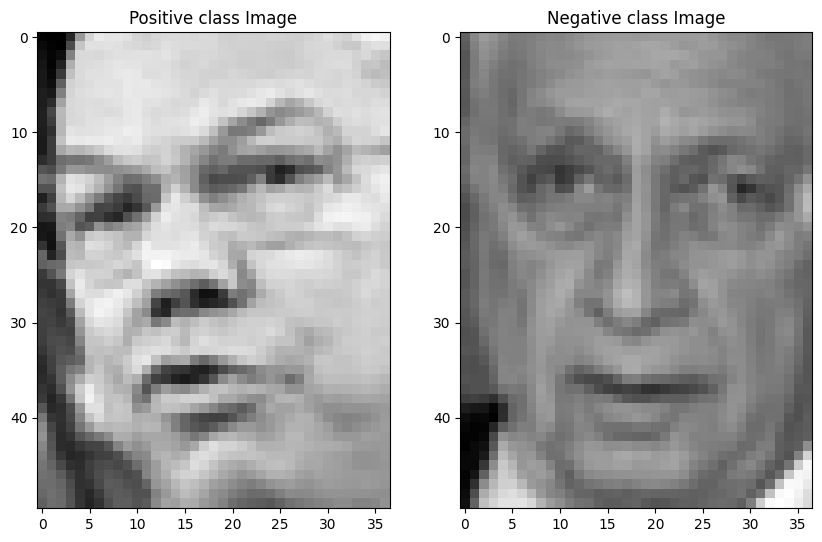

In [42]:
# Plot a positive and negative image for classifications purposes
plt.figure(figsize=(10,10))
# Positive
plt.subplot(1,2,1)
plt.imshow(X[y==1][0], cmap='gray')
plt.title('Positive class Image')
# Negative
plt.subplot(1,2,2)
plt.imshow(X[y==0][0], cmap='gray')
plt.title('Negative class Image')

In [43]:
# This will show us if we are ir [0,1] range or [0, 255]
np.min(X),np.max(X)

(0.0, 1.0)

As we can see, we don't have to normalize the images to [0, 1] range cause we already are in it

In [44]:
# We want to know how many people we have in the dataset to classify
len(np.unique(y))

10

### First dataset implementations

#### Data preprocessing

In [45]:
X_reshape = X.reshape((X.shape[0], -1 )) # Flatten image

labelEncoder = LabelEncoder()
y_encoded = labelEncoder.fit_transform(y)
X_reshape.shape, y_encoded.shape

((1456, 1850), (1456,))

#### Split the dataset

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y_encoded, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 1850), (292, 1850), (1164,), (292,))

#### Classifiers

##### SVC ( Support Vector Machines)

In [47]:
svm_classifier = SVC()

svm_classifier.fit(X_train, (y_train==1))

SVC()

In [48]:
y_pred = svm_classifier.predict(X_test)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred)}')
print(f'\nConfusion-Matrix: \n{confusion_matrix(y_test==1, y_pred)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred)}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred)}')

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       246
        True       1.00      0.63      0.77        46

    accuracy                           0.94       292
   macro avg       0.97      0.82      0.87       292
weighted avg       0.95      0.94      0.94       292


Confusion-Matrix: 
[[246   0]
 [ 17  29]]

ROC-AUC-Score: 
0.8152173913043479

Accuracy-Score: 
0.9417808219178082


Como svm es un clasificador binario, tenemos que utilizar un OneVsRestClassifier que es un clasificador de Uno-Muchos ya que no podemos dibujar una curva roc con todas las clases

In [ ]:
ovr_classifier = OneVsRestClassifier(svm_classifier)

ovr_classifier.fit(X_train, y_train)

y_pred_prob = ovr_classifier.predict_proba(X_train)

fpr = dict()
tpr = dict()
auc = dict()
for i in range(len(ovr_classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_train == ovr_classifier.classes_[i]), y_pred_prob[:, i])
    auc[i] = roc_auc_score((y_train == ovr_classifier.classes_[i]), y_pred_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(ovr_classifier.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (AUC = {:.2f})'.format(ovr_classifier.classes_[i], auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
plt.legend(loc="lower right")
plt.show()

##### Logistic Regression 

In [11]:
logisticClassifier = LogisticRegression()

logisticClassifier.fit(X_train, (y_train==1))

LogisticRegression()

In [12]:
y_pred = logisticClassifier.predict(X_test)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred)}')
print(f'\nConfusion-Matrix: \n{confusion_matrix(y_test==1, y_pred)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred)}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred)}')

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       246
        True       0.86      0.83      0.84        46

    accuracy                           0.95       292
   macro avg       0.92      0.90      0.91       292
weighted avg       0.95      0.95      0.95       292


Confusion-Matrix: 
[[240   6]
 [  8  38]]

ROC-AUC-Score: 
0.9008483563096501

Accuracy-Score: 
0.952054794520548


##### Neural Network

In [13]:
# Aqui pasamos a one-hot encoding las etiquetas para poder diferenciar las 10 clases de las im'agenes
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [14]:
neuralModelo = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
neuralModelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neuralModelo.summary()

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       118,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,402 (489.85 KB)

 Trainable params: 125,402 (489.85 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = neuralModelo.fit(X_train, (y_train==1), epochs=1000, batch_size=64, validation_split=.2)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0791 - loss: 2.3085 - val_accuracy: 0.0386 - val_loss: 2.1807
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1956 - loss: 2.2135 - val_accuracy: 0.3820 - val_loss: 2.1392
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3447 - loss: 2.1711 - val_accuracy: 0.3820 - val_loss: 2.0855
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3615 - loss: 2.1100 - val_accuracy: 0.3820 - val_loss: 2.0531
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3694 - loss: 2.0386 - val_accuracy: 0.3820 - val_loss: 1.9922
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3513 - loss: 1.9963 - val_accuracy: 0.4421 - val_loss: 1.9233
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3625 - loss: 2.0185 - val_accuracy: 0.4464 - val_loss: 1.8201
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3846 - loss: 1.8748 - val_accuracy: 0

In [16]:
y_pred_neural = neuralModelo.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_neural)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_neural)}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_neural)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Results:
Classification-Report:
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        14
           1       0.93      0.61      0.74        46
           2       1.00      0.27      0.42        26
           3       0.95      0.59      0.73       106
           4       0.67      0.18      0.29        11
           5       1.00      0.35      0.52        17
           6       1.00      0.11      0.20         9
           7       0.00      0.00      0.00        18
           8       1.00      0.08      0.15        12
           9       1.00      0.24      0.39        33

   micro avg       0.95      0.41      0.57       292
   macro avg       0.86      0.27      0.39       292
weighted avg       0.90      0.41      0.54       292
 samples avg       0.41      0.41      0.41       292


ROC-AUC-Score: 
0.6350895271248923

Accuracy-Score: 
0.410958904109589


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


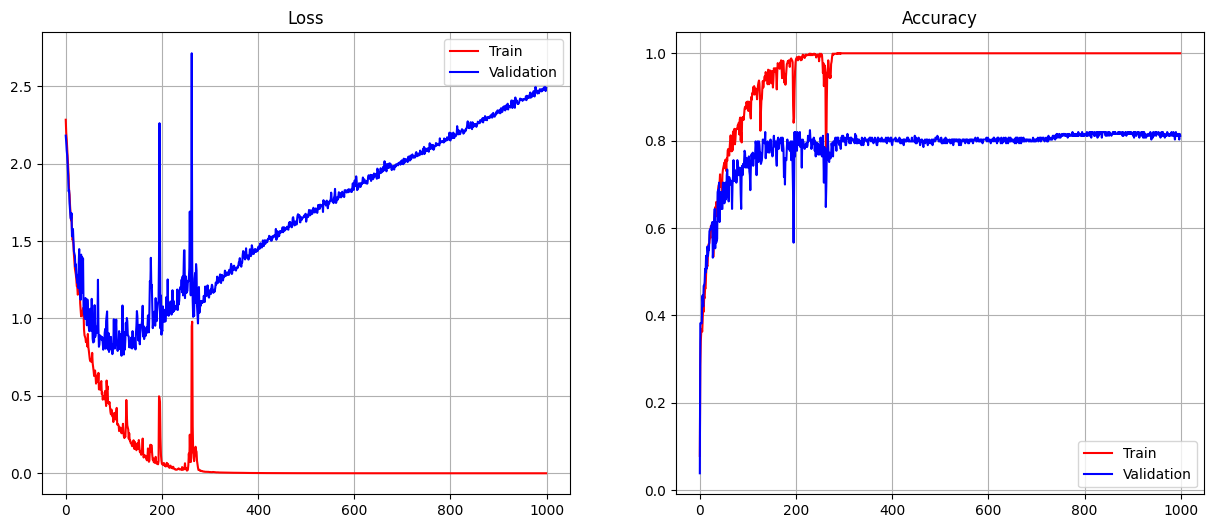

In [17]:
plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train', c='red')
plt.plot(history.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train', c='red')
plt.plot(history.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
acierto, fallo = 0,0

for a,b in zip(y_pred_neural, y_test):
    if(b[1]==1):
        #7print(a, '\t', b)
        if (a[1]==1):
            acierto +=1
        else:
            fallo += 1
print(f"Acierto (%total) = {acierto} ({acierto+fallo}) -->  {acierto/(acierto+fallo)*100:.4f}%")

Acierto (%total) = 28 (46) -->  60.8696%


#### CNN (alexNet)

In [19]:
# Vamos a volver a cargar los datos para pasarlo a los tensores necesarios parar que funcione el algoritmo

lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target


In [20]:
# aplicamos un encoder sobre los labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [21]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 50, 37), (292, 50, 37), (1164,), (292,))

In [22]:
# Agregamos una dimension adicional para el canal de color (estamos originalmente en una escala de grises)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape, X_test.shape

((1164, 50, 37, 1), (292, 50, 37, 1))

In [23]:
# Cambiamos a one hot enconding las etiquetas
y_train =   to_categorical(y_train)
y_test =    to_categorical(y_test)

In [24]:
# Definimos el modelo
#
num_epochs = 25
#
modeloCNN = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=( X_train.shape[1], X_train.shape[2], 1) ),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
    ])
#
modeloCNN.summary()
#
modeloCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#
earlyStop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
historyCNN = modeloCNN.fit(X_train, y_train==1, epochs=num_epochs, batch_size=16, callbacks=[earlyStop], validation_split=.25)

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 35, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,122 (477.04 KB)

 Trainable params: 122,122 (477.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1252 - loss: 0.4996 - val_accuracy: 0.3814 - val_loss: 0.2875
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3414 - loss: 0.2936 - val_accuracy: 0.3814 - val_loss: 0.2865
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3734 - loss: 0.2895 - val_accuracy: 0.3814 - val_loss: 0.2847
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3742 - loss: 0.2864 - val_accuracy: 0.3814 - val_loss: 0.2854
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3420 - loss: 0.2909 - val_accuracy: 0.3814 - val_loss: 0.2841
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3415 - loss: 0.2946 - val_accuracy: 0.3814 - val_loss: 0.2841
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3522 - loss: 0.2876 - val_accuracy: 0.3814 - val_loss: 0.2820
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3813 - loss: 0.2822 - val_accuracy: 0.3814 - val_loss

In [25]:
y_pred_CNN = modeloCNN.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_CNN)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_CNN)}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_CNN)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Results:
Classification-Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       1.00      0.15      0.26        46
           2       0.00      0.00      0.00        26
           3       0.97      0.26      0.41       106
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        33

   micro avg       0.97      0.12      0.21       292
   macro avg       0.20      0.04      0.07       292
weighted avg       0.51      0.12      0.19       292
 samples avg       0.12      0.12      0.12       292


ROC-AUC-Score: 
0.5205474256176842

Accuracy-Score: 
0.11986301369863013


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


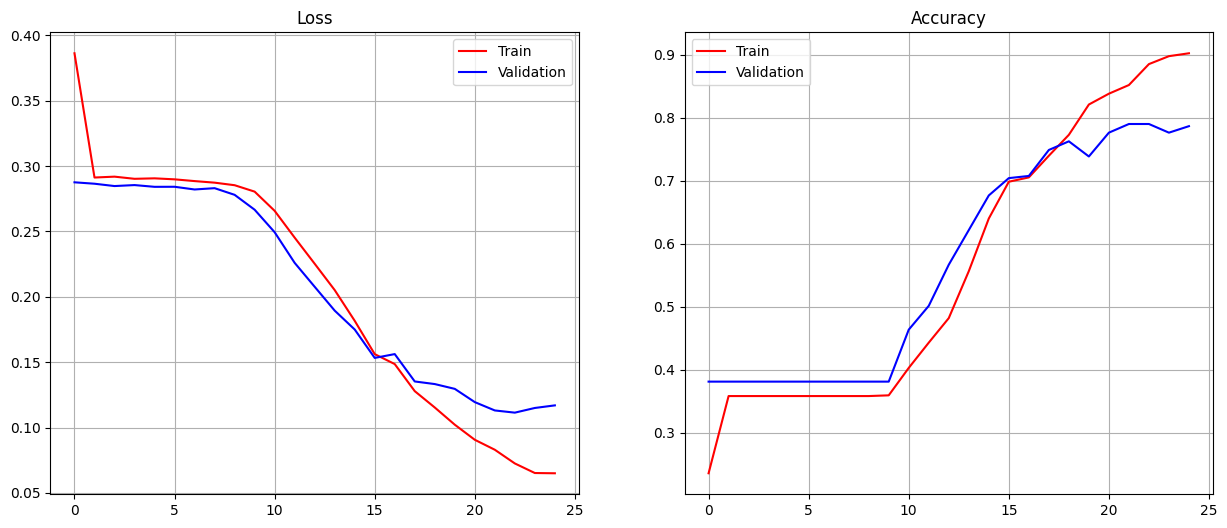

In [26]:

plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(historyCNN.history['loss'], label='Train', c='red')
plt.plot(historyCNN.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(historyCNN.history['accuracy'], label='Train', c='red')
plt.plot(historyCNN.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
acierto, fallo = 0, 0

for a,b in zip(y_pred_CNN, y_test):
    if(b[1]==1):
        #7print(a, '\t', b)
        if (a[1]==1):
            acierto +=1
        else:
            fallo += 1
print(f"Aciertos | Fallos (%total) = {acierto} | {fallo} ({acierto/(acierto+fallo)*100:.4f}%)")

Aciertos | Fallos (%total) = 7 | 39 (15.2174%)
